<a href="https://colab.research.google.com/github/SamuelJordanTK/AI-MACHINE_LEARNING-DATA-SCIENCE-BOOTCAMP/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 344.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=77cfa24ce04ae0a914023a32b1f049828afafb1255c60656b8381601a7f40f77
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=49d8f2116ceb8a733fa10f13432d0faae8a836f5700798540c17443a702b7dbf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pyto

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


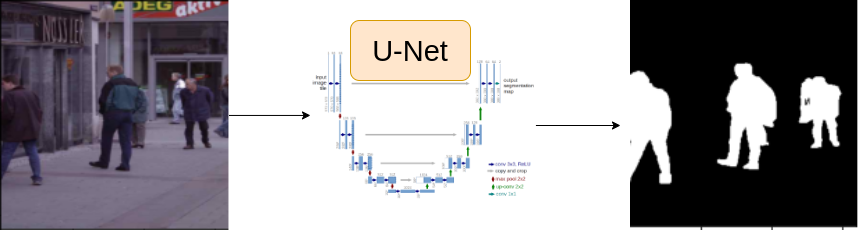

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
Data_dir = '/content/'

Device = 'Cuda'

EPOCHS =25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

Encoder = 'timm-efficientnet-b0'
Weights = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

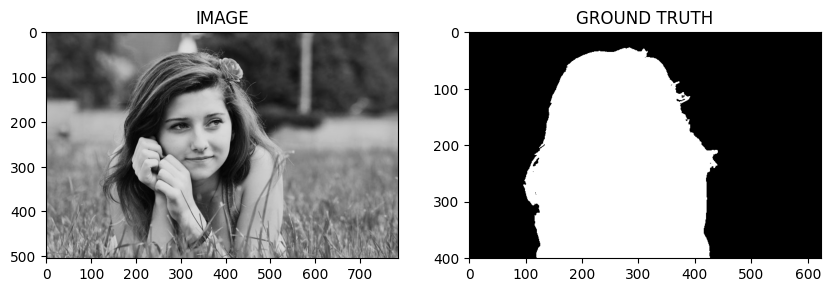

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.5.0). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Here we have the image format (heigth, weigth, channel)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:

      # Check if image and mask have the same dimensions
        if image.shape[:2] != mask.shape[:2]:
            # Resize mask to match image dimensions
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        data = self.augmentations(image = image, mask=mask)
        image = data['image']
        mask = data['mask']

    # Convert the image format from (h, w, c) to (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    # Check if mask has 3 dimensions before transposing
    if mask.ndim == 3:  # Check if mask has 3 dimensions
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    else:  # If mask is 2D, add a channel dimension
        mask = mask[np.newaxis, ...].astype(np.float32)

    #Transform image into Tensors
    image = torch.Tensor(image)/ 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validationset = SegmentationDataset(valid_df, get_train_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validationset)}")

Size of Trainset : 232
Size of Validset : 58


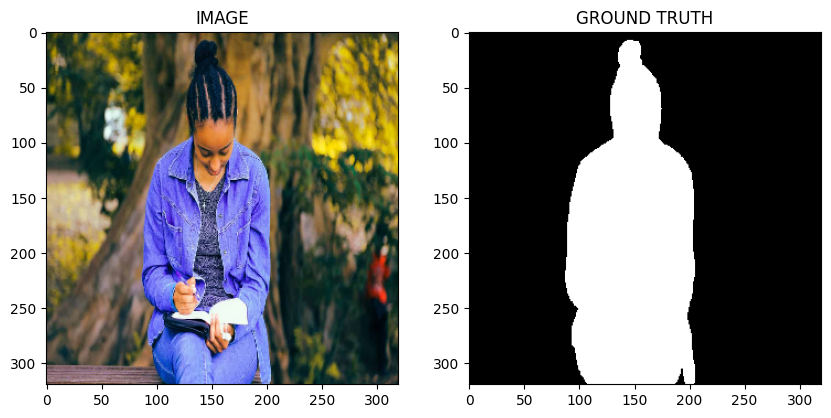

In [ ]:
idx = 30

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validationloader = DataLoader(validationset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validationloader : {len(validationloader)}")

Total number of batches in trainloader : 15
Total number of batches in validationloader : 4


In [ ]:
for images, masks in trainloader:
  break

print(f'One batch image shape:', images.shape)
print(f'One batch mask shape:', masks.shape)

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc  = smp.Unet(
        encoder_name = Encoder,
        encoder_weights = Weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [60]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validationloader, model)

  if valid_loss < best_valid_loss:

    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED MODEL:')
    best_valid_loss = valid_loss
  print(f"Epoch : {epoch+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


SAVED MODEL:
Epoch : 1 Train Loss: 0.7132071375846862 Valid Loss: 0.8448195159435272


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


SAVED MODEL:
Epoch : 2 Train Loss: 0.3760197420914968 Valid Loss: 0.32569942995905876


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 3 Train Loss: 0.33209635814030963 Valid Loss: 0.32610081508755684


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


SAVED MODEL:
Epoch : 4 Train Loss: 0.2894755780696869 Valid Loss: 0.25005967542529106


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


SAVED MODEL:
Epoch : 5 Train Loss: 0.22473005553086597 Valid Loss: 0.24979713931679726


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


SAVED MODEL:
Epoch : 6 Train Loss: 0.20333576301733652 Valid Loss: 0.21755466051399708


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 7 Train Loss: 0.20936339100201926 Valid Loss: 0.24418584629893303


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 8 Train Loss: 0.18406067192554473 Valid Loss: 0.28676798194646835


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


SAVED MODEL:
Epoch : 9 Train Loss: 0.18967009236415228 Valid Loss: 0.17491180077195168


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 10 Train Loss: 0.18045355876286825 Valid Loss: 0.20127211138606071


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


SAVED MODEL:
Epoch : 11 Train Loss: 0.15410899420579274 Valid Loss: 0.17162670567631721


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch : 12 Train Loss: 0.13419203261534374 Valid Loss: 0.19401460886001587


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 13 Train Loss: 0.13273468613624573 Valid Loss: 0.1750587485730648


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch : 14 Train Loss: 0.14032576531171798 Valid Loss: 0.19967875070869923


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 15 Train Loss: 0.1277195448676745 Valid Loss: 0.204286627471447


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch : 16 Train Loss: 0.1425670141975085 Valid Loss: 0.2093753144145012


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


Epoch : 17 Train Loss: 0.15021807799736658 Valid Loss: 0.2190938964486122


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 18 Train Loss: 0.1571338971455892 Valid Loss: 0.20329231768846512


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch : 19 Train Loss: 0.13607649902502697 Valid Loss: 0.21594948321580887


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch : 20 Train Loss: 0.1281759535272916 Valid Loss: 0.18457869440317154


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Epoch : 21 Train Loss: 0.16248952249685925 Valid Loss: 0.26405250653624535


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 22 Train Loss: 0.14465043594439825 Valid Loss: 0.21823455020785332


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


SAVED MODEL:
Epoch : 23 Train Loss: 0.11587229520082473 Valid Loss: 0.16856761276721954


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch : 24 Train Loss: 0.12799625992774963 Valid Loss: 0.17548636719584465


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

Epoch : 25 Train Loss: 0.15624381800492604 Valid Loss: 0.21483763679862022


# Task 9 : Inference

In [68]:
idx = 22

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validationset[idx]

logits_mask, _ = model(image.to(DEVICE).unsqueeze(0), mask.to(DEVICE).unsqueeze(0)) # Pass mask to the model
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-68-ce7c33291760>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


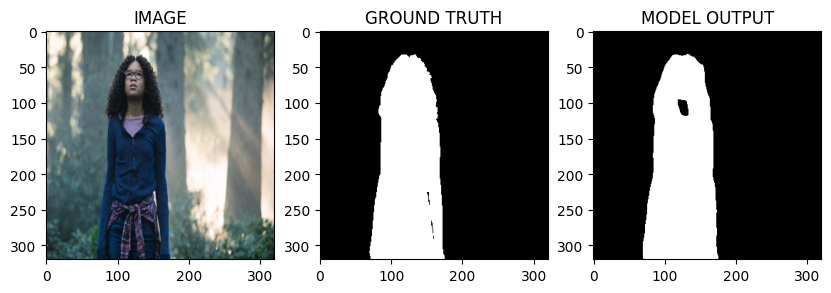

In [69]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya